In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

In [2]:
df = pd.read_parquet("transactional_dataset_train.parquet")
df.head()

,account_id,event_time,amount
0,132285932,2021-08-14 21:18:04.956,19.99
1,131792942,2021-08-14 21:28:33.266,9.99
2,180084640,2021-08-14 19:10:59.833,0.99
3,132486244,2021-08-14 20:35:14.897,9.99
4,131970262,2021-08-14 19:30:59.234,0.99


In [3]:
summary = lifetimes.utils.summary_data_from_transaction_data(df,"account_id","event_time","amount",freq='s',freq_multiplier=86400)
summary = summary.reset_index()
summary.sort_values(by="frequency",ascending = False)

,account_id,frequency,recency,T,monetary_value
67223,98491143,103.0,2.189190,176.550914,26.718155
50591,167529481,96.0,2.891840,60.774086,12.594167
10480,113958422,88.0,1.664942,86.127986,30.058182
52280,169616730,82.0,2.894387,50.590313,34.770488
19734,123433842,80.0,2.371910,43.490475,9.152500
...,...,...,...,...,...
29364,129610414,0.0,0.000000,16.880255,0.000000
29366,129610564,0.0,0.000000,16.507118,0.000000
29370,129611652,0.0,0.000000,15.681123,0.000000
29375,129612734,0.0,0.000000,16.873623,0.000000


count    69858.000000
mean         1.304604
std          2.965060
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        103.000000
Name: frequency, dtype: float64
percentage of one time buyers 57.11


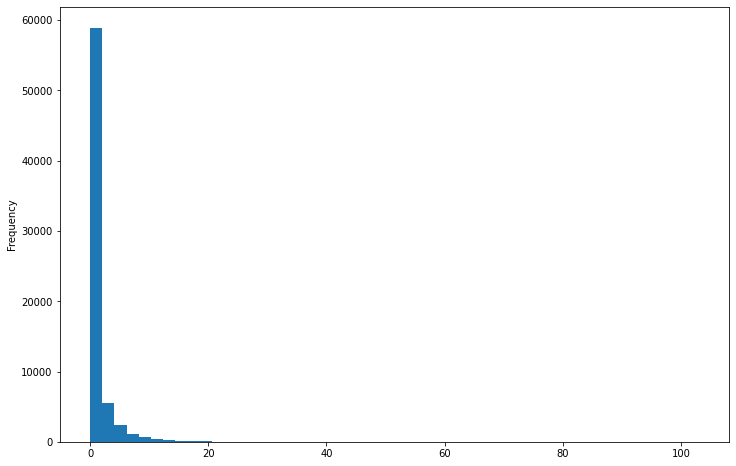

In [4]:
fig = plt.figure(figsize=(12,8))
summary["frequency"].plot(kind="hist",bins = 50)
print(summary["frequency"].describe())
percentage = sum(summary["frequency"]==0)/(len(summary))*(100)
print(f"percentage of one time buyers { round(percentage,2)}")
#základna popisná štatistika summary tabuľlky nášho datasetu plus podiel one time buyerov a jednoduchý histogram na kotorom 
#vidno početnosť zákazníkov, prevládajú hráči čo nákupili 5-krát a menej. s grafmi sa ešte určite pohrám 

In [5]:
mbg = lifetimes.fitters.modified_beta_geo_fitter.ModifiedBetaGeoFitter()
mbg.fit(summary["frequency"],summary["recency"],summary["T"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 69858 subjects, a: 2.38, alpha: 0.03, b: 1.93, r: 0.52>

In [8]:
summary["probability_alive"] = mbg.conditional_probability_alive(summary["frequency"],summary["recency"],summary["T"])
summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674646
36569,133551363,6.0,2.042292,2.214340,8.323333,0.665071
64380,180987991,3.0,2.932812,3.137315,14.323333,0.621258
36052,133084422,8.0,2.930775,3.306019,8.365000,0.602229
36499,133456254,3.0,2.768067,3.137569,1.656667,0.572907
64446,181052341,6.0,1.896447,2.187998,8.323333,0.571538
64327,180936061,2.0,2.704537,3.085093,14.990000,0.543652
64360,180969271,4.0,1.972569,2.331088,8.740000,0.542787
64344,180952230,4.0,1.202164,1.434699,4.240000,0.533812
36376,133336564,3.0,2.818935,3.434167,8.323333,0.510658


c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\lifetimes\fitters\modified_beta_geo_fitter.py:213: RuntimeWarning: overflow encountered in power
  return np.atleast_1d(1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency)))


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

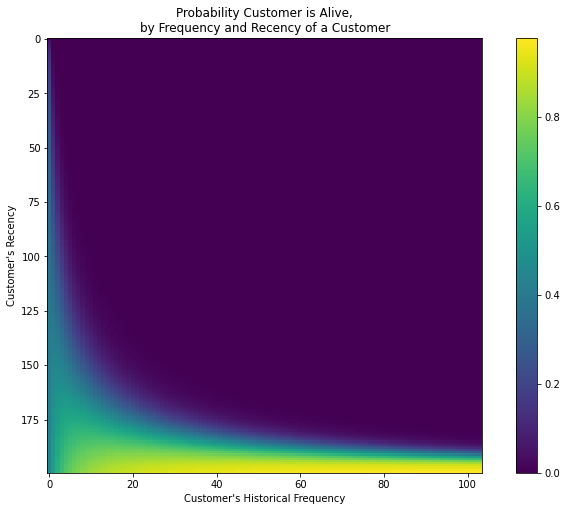

In [7]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbg)

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

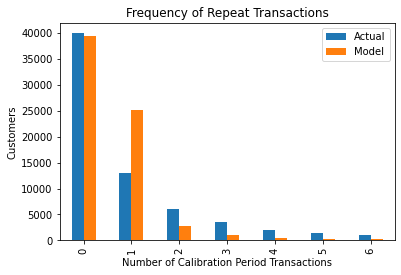

In [9]:
plot_period_transactions(mbg)

c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\lifetimes\fitters\modified_beta_geo_fitter.py:184: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (a / (b + x)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

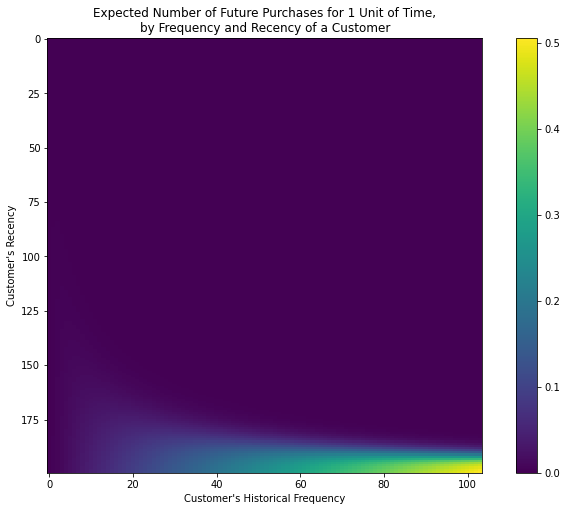

In [10]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(mbg)

In [11]:
t=10 #ešte overím či to berie ako dni ked je celý dataset v dňoch alebo to treba špecifikovať.
summary["predicted_num_of_purchases"]=round(mbg.conditional_expected_number_of_purchases_up_to_time(10,summary["frequency"],summary["recency"],summary["T"]),2)
summary.sort_values(by="probability_alive",ascending = False).head()

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674646,3.55
36569,133551363,6.0,2.042292,2.214340,8.323333,0.665071,4.15
64380,180987991,3.0,2.932812,3.137315,14.323333,0.621258,2.29
36052,133084422,8.0,2.930775,3.306019,8.365000,0.602229,4.20
36499,133456254,3.0,2.768067,3.137569,1.656667,0.572907,2.11


In [12]:
gamma_summary = summary[summary["frequency"]>0]
gamma_summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674646,3.55
36569,133551363,6.0,2.042292,2.214340,8.323333,0.665071,4.15
64380,180987991,3.0,2.932812,3.137315,14.323333,0.621258,2.29
36052,133084422,8.0,2.930775,3.306019,8.365000,0.602229,4.20
36499,133456254,3.0,2.768067,3.137569,1.656667,0.572907,2.11
64446,181052341,6.0,1.896447,2.187998,8.323333,0.571538,3.57
64327,180936061,2.0,2.704537,3.085093,14.990000,0.543652,1.59
64360,180969271,4.0,1.972569,2.331088,8.740000,0.542787,2.59
64344,180952230,4.0,1.202164,1.434699,4.240000,0.533812,2.79
36376,133336564,3.0,2.818935,3.434167,8.323333,0.510658,1.83


In [13]:
gamma_summary[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.185931
monetary_value,0.185931,1.000000


In [14]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(gamma_summary["frequency"],
        gamma_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 29962 subjects, p: 2.61, q: 1.58, v: 2.09>

In [15]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.613708,0.021685,2.571205,2.656211
q,1.580132,0.012436,1.555757,1.604506
v,2.092974,0.022627,2.048625,2.137324


In [16]:
summary = summary[summary["monetary_value"]>0]
summary["exp_avg_sales"] = ggf.conditional_expected_average_profit(summary["frequency"],
                                                                   summary["monetary_value"])
summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales
36554,133513494,3.0,0.076725,0.076725,13.323333,0.674646,3.55,13.055100
36569,133551363,6.0,2.042292,2.214340,8.323333,0.665071,4.15,8.362798
64380,180987991,3.0,2.932812,3.137315,14.323333,0.621258,2.29,13.986211
36052,133084422,8.0,2.930775,3.306019,8.365000,0.602229,4.20,8.393740
36499,133456254,3.0,2.768067,3.137569,1.656667,0.572907,2.11,2.192138
64446,181052341,6.0,1.896447,2.187998,8.323333,0.571538,3.57,8.362798
64327,180936061,2.0,2.704537,3.085093,14.990000,0.543652,1.59,14.434559
64360,180969271,4.0,1.972569,2.331088,8.740000,0.542787,2.59,8.776255
64344,180952230,4.0,1.202164,1.434699,4.240000,0.533812,2.79,4.512830
36376,133336564,3.0,2.818935,3.434167,8.323333,0.510658,1.83,8.399545


In [17]:
print(f"očakávané priemerné príjmy: {np.mean(summary['exp_avg_sales'])}")
print(f"skutočné priemerné príjmy: {np.mean(summary['monetary_value'])}")

očakávané priemerné príjmy: 6.497463024765826
skutočné priemerné príjmy: 6.044814661581698
